In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

import seaborn as sns; sns.set_theme(color_codes=True)
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import plotly.express as p
import pandas as pd
import datetime
import numpy as np
import math

#from hisia import Hisia

In [37]:
client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')

In [38]:
def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df


# Get the last 14600 days (40 years) of power generation data
power = client.query(
    "SELECT mean(Total) FROM Generation WHERE time > now()-3624d GROUP BY time(3h)"
    ) # Query written in InfluxQL

# Get the last 14600 days (40 years) of weather forecasts with the shortest lead time
forecast = client.query( 
        "SELECT * FROM MetForecasts WHERE time > now()-3624d and time <= now()-1d"
        ) # Query written in InfluxQL

power_df = get_df(power)
forecast_df = get_df(forecast)

In [39]:
# Exploring the tables
display(power_df.head())
display(forecast_df.head())

,mean
time,
2012-02-02 12:00:00+00:00,3.554000
2012-02-02 15:00:00+00:00,3.595944
2012-02-02 18:00:00+00:00,3.600111
2012-02-02 21:00:00+00:00,2.308122
2012-02-03 00:00:00+00:00,0.973722


,Direction,Lead_hours,Source_time,Speed
time,,,,
2019-03-28 12:00:00+00:00,SW,1,1553767200,16.98752
2019-03-28 15:00:00+00:00,SW,1,1553778000,16.09344
2019-03-28 15:00:00+00:00,SW,2,1553774400,16.09344
2019-03-28 15:00:00+00:00,SW,3,1553770800,15.19936
2019-03-28 15:00:00+00:00,SW,4,1553767200,15.19936


In [40]:
# Check shape and data types
print(power_df.shape)
print(forecast_df.shape, '\n') 


print('Power generation data types:', '\n', power_df.dtypes, '\n',)
print('Weather forecast data types:', '\n', forecast_df.dtypes)

(28993, 1)
(825644, 4) 

Power generation data types: 
 mean    float64
dtype: object 

Weather forecast data types: 
 Direction       object
Lead_hours      object
Source_time      int64
Speed          float64
dtype: object


In [41]:
# Check how many nan's
print('NaNs in power generation:', power_df.isnull().sum())
power_nans = 4331/28993
print('Fraction of Nans in power generation', round(power_nans, 2), '\n')

print('NaNs in weather forecast:', forecast_df.isnull().sum())

NaNs in power generation: mean    4360
dtype: int64
Fraction of Nans in power generation 0.15 

NaNs in weather forecast: Direction      0
Lead_hours     0
Source_time    0
Speed          0
dtype: int64


In [42]:
#Direction and lead hours are cast into appropriate data types
forecast_df["Direction"] = forecast_df["Direction"].astype("category")
forecast_df["Lead_hours"] = forecast_df["Lead_hours"].astype("int64")

print(forecast_df.dtypes)

Direction      category
Lead_hours        int64
Source_time       int64
Speed           float64
dtype: object


array([[<AxesSubplot:title={'center':'mean'}>]], dtype=object)

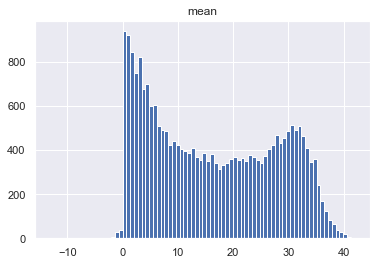

In [43]:
# Check distribution
power_df.hist(column="mean", bins=80)

In [44]:
power_copy = power_df.copy()    # Making a copy to not mess with OG data 

power_copy.fillna(method="bfill", inplace = True)    # Backfilling data
print(power_copy["mean"].mean())    # Taking the mean

power_copy

17.791484921483473


,mean
time,
2012-02-02 12:00:00+00:00,3.554000
2012-02-02 15:00:00+00:00,3.595944
2012-02-02 18:00:00+00:00,3.600111
2012-02-02 21:00:00+00:00,2.308122
2012-02-03 00:00:00+00:00,0.973722
...,...
2022-01-04 00:00:00+00:00,31.279500
2022-01-04 03:00:00+00:00,27.795248
2022-01-04 06:00:00+00:00,27.795248


In [45]:
# Merging the two dataframes
merged_df = forecast_df.join(power_copy)
merged_df

,Direction,Lead_hours,Source_time,Speed,mean
time,,,,,
2019-03-28 12:00:00+00:00,SW,1,1553767200,16.98752,28.059611
2019-03-28 15:00:00+00:00,SW,1,1553778000,16.09344,27.354461
2019-03-28 15:00:00+00:00,SW,2,1553774400,16.09344,27.354461
2019-03-28 15:00:00+00:00,SW,3,1553770800,15.19936,27.354461
2019-03-28 15:00:00+00:00,SW,4,1553767200,15.19936,27.354461
...,...,...,...,...,...
2022-01-03 12:00:00+00:00,WNW,9,1641175200,12.96416,29.826906
2022-01-03 12:00:00+00:00,WSW,80,1640919600,11.17600,29.826906
2022-01-03 12:00:00+00:00,WSW,81,1640916000,11.17600,29.826906


In [46]:
print(merged_df.isnull().sum())

Direction      0
Lead_hours     0
Source_time    0
Speed          0
mean           0
dtype: int64


array([[<AxesSubplot:title={'center':'Speed'}>]], dtype=object)

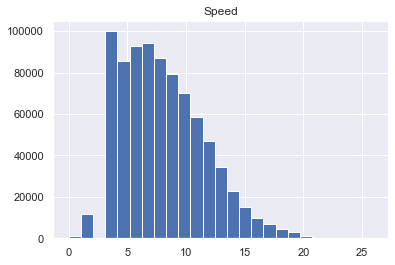

In [47]:
merged_df.hist(column="Speed", bins=25)

In [ ]:
#Outlier detection
fig = px.box(merged_df, y="mean", 
              width=500, height=400)
fig.show()

In [ ]:
fig = px.box(merged_df, y="Speed", 
             width=500, height=400)
fig.show()

In [48]:
merged_df.describe()

,Lead_hours,Source_time,Speed,mean
count,825644.000000,8.256440e+05,825644.000000,825644.000000
mean,54.334764,1.598121e+09,8.223915,16.947759
std,31.370526,2.505350e+07,3.493298,11.694881
min,1.000000,1.553767e+09,0.000000,-1.449078
25%,27.000000,1.576681e+09,5.811520,5.910978
50%,54.000000,1.598000e+09,8.046720,15.080917
75%,81.000000,1.619942e+09,9.834880,27.666184
max,119.000000,1.641204e+09,25.928320,41.992789


In [ ]:
sns.pairplot(merged_df)

In [49]:
#Surprisingly only positive correlation found between speed and power generation /s
print(merged_df.corr())

             Lead_hours  Source_time     Speed      mean
Lead_hours     1.000000    -0.001371  0.015077 -0.001007
Source_time   -0.001371     1.000000 -0.023313 -0.079991
Speed          0.015077    -0.023313  1.000000  0.740156
mean          -0.001007    -0.079991  0.740156  1.000000


<AxesSubplot:xlabel='Speed', ylabel='mean'>

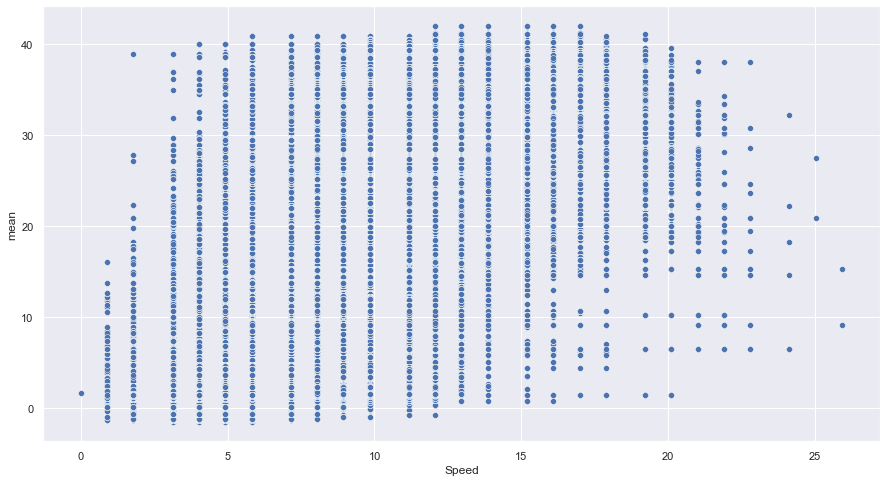

In [50]:
#Shows that the correlation is not linear
plt.figure(figsize=(15,8))
sns.scatterplot(data = merged_df, 
                x = "Speed", 
                y = "mean")

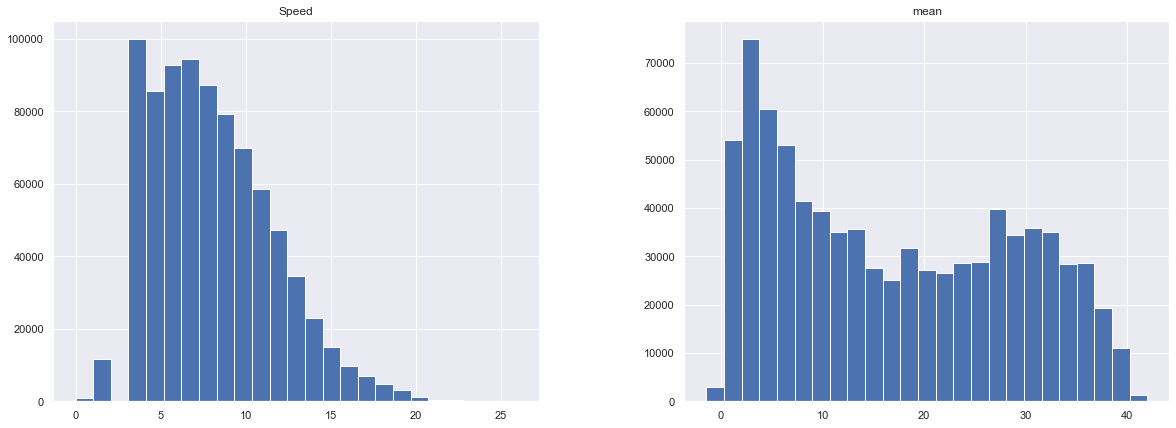

In [51]:
#Plotting histogram of wind speed and power generation side by side to visualize correlation
hist_df = merged_df.iloc[:,-2:]
hist_df.hist(bins = 25, 
             figsize=(20,7))
plt.show()

In [ ]:
# All features except Wind power are defined as independent variables
X = merged_df.iloc[:,:-1]
# Wind power is defined as dependent variable
y = merged_df.iloc[:,-1:]

In [ ]:
print(X.dtypes)
X.head()

In [ ]:
# Most of the below code is taken from the docs here:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    shuffle = True,
                                                    test_size = 0.2)

# Numeric transformer uses MinMaxScaler to scale values between the set range of 0-1
# Categorical transformer uses OrdinalEncoder to encode Direction values from 1-16
# Creating lists of categorical and numerical features to be used in column transformer

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])
numeric_features = list(X_train.select_dtypes('number').columns)

categorical_transformer = OrdinalEncoder(handle_unknown='ignore')
categorical_features = list(X_train.select_dtypes('category').columns)

# Feeding transformers and features to preprocessor
train_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Creating pipeline with preprocessor and LinReg model
pipe = Pipeline(steps=[('preprocessor', train_preprocessor),
                      ('predictor', LinearRegression())])
# Fitting model
model = pipe.fit(X_train, y_train)

In [ ]:
# Model prediction
y_hat = model.predict(X_test)

rmse = math.sqrt(mean_squared_error(y_test, y_hat))
r2 = r2_score(y_test, y_hat)

print("RMSE", rmse)
print("R2", r2)

In [ ]:
#Prints the 10-fold cross validated scores of the above metrics
rmse_score = cross_val_score(model,
                             X, y,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 10)
print("Average 10-Fold CV Score (RMSE):", np.mean(rmse_score))


r2_score = cross_val_score(model,
                             X, y,
                             scoring = 'r2',
                             cv = 10)
print("Average 10-Fold CV Score (R2):", np.mean(r2_score))

#Model appears to generalize well to unseen data

In [ ]:
ax1 = sns.distplot(y_test, 
                   hist = True, 
                   color = "r", 
                   label = "Actual Value")
sns.distplot(y_hat, 
             hist = True, 
             color = "b", 
             label = "Fitted Values", 
             ax = ax1)
ax1.legend()